In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, average_precision_score, classification_report

In [28]:
# Data Loading and Pre- Processing
df = pd.read_csv('/content/cleaned_new_train_EGN5442.csv')
print(df)

        Unnamed: 0  y  x3  x9  x10  x11  x12  x13  x14  x15  ...  x20  x21  \
0                0  1   0   5    5    5    4    3    5    3  ...    3    4   
1                1  1   0   1    1    1    1    3    3    1  ...    4    4   
2                2  0   0   3    1    5    5    3    2    2  ...    1    3   
3                3  0   0   1    3    1    3    5    1    5  ...    1    4   
4                4  1   1   5    5    5    5    2    5    5  ...    4    4   
...            ... ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   
104717      104717  1   1   5    5    5    5    5    5    5  ...    3    5   
104718      104718  0   0   1    4    4    4    4    2    4  ...    3    1   
104719      104719  0   1   3    4    3    5    1    3    1  ...    3    4   
104720      104720  0   1   2    4    2    2    4    2    4  ...    2    3   
104721      104721  1   0   3    3    3    3    2    5    5  ...    3    2   

        x22  x23  x25  x26  x28        x31  x4  x6  
0         

In [29]:
y= df['y']
X= df.drop(columns= ['y'])

In [30]:
# First split: 70-30
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size= 0.30, stratify= y, random_state = 42)

In [31]:
# Second split: 15% validation + 15% testing
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, stratify= y_temp, random_state= 42)

In [32]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(73305, 23)
(15708, 23)
(15709, 23)

(73305,)
(15708,)
(15709,)


In [33]:
# Scaling
scaler= StandardScaler()

#fit only on train data
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [34]:
# Parameter search space
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C': loguniform(1e-3, 1e2),
    'solver': ['liblinear', 'saga'],
    'max_iter': [3000]
}

model = LogisticRegression()

# Cross validation

search = RandomizedSearchCV(
    estimator = model,
    param_distributions= param_grid,
    n_iter=25,
    scoring= 'roc_auc',
    n_jobs=-1, cv=5, verbose=1

)

In [35]:
search.fit(X_train_s, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=25, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e4277490380>,
                                        'max_iter': [3000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='roc_auc', verbose=1)

In [36]:
print("Best params:", search.best_params_)
best_model= search.best_estimator_

Best params: {'C': np.float64(16.80977386807004), 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}


In [37]:
# Evaluating on Training, Validation and Testing

#train
train_proba = best_model.predict_proba(X_train_s)[:, 1]
train_auc = metrics.roc_auc_score(y_train, train_proba)
print(train_auc)

0.9421090387125202


In [38]:
# Validation
y_val_pred  = best_model.predict(X_val_s)
y_val_proba = best_model.predict_proba(X_val_s)[:,1]
val_auc = metrics.roc_auc_score(y_val, y_val_proba)
print(val_auc)

0.9413060921796114


In [39]:
# Testing
y_test_pred  = best_model.predict(X_test_s)
y_test_proba = best_model.predict_proba(X_test_s)[:,1]
test_auc = roc_auc_score(y_test, y_test_proba)
print(test_auc)


0.9419525460877295


In [40]:
# Refit scaler and model on train+val
X_trv = np.vstack([X_train_s, X_val_s])
y_trv = np.concatenate([y_train, y_val])

best_params = search.best_params_
lg_final = LogisticRegression(**best_params)
lg_final.fit(X_trv, y_trv)

# Final evaluation on test
test_proba_final = lg_final.predict_proba(X_test_s)[:, 1]
test_auc = roc_auc_score(y_test, test_proba_final)
test_pr_auc = average_precision_score(y_test, test_proba_final)

# Predictions with default 0.5 threshold
y_test_pred  = (test_proba_final >= 0.5).astype(int)

<Figure size 600x500 with 0 Axes>

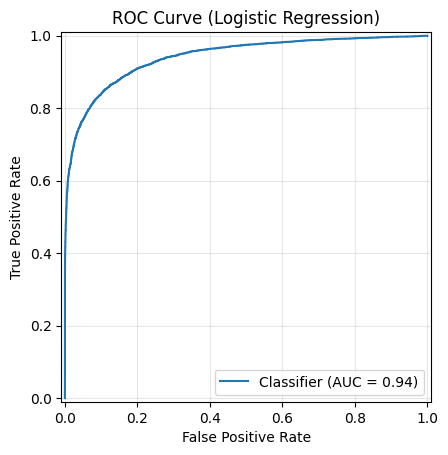

<Figure size 500x400 with 0 Axes>

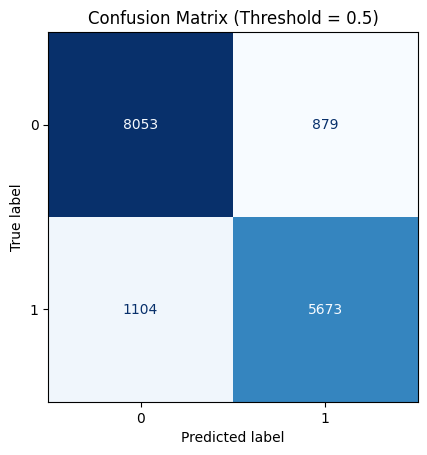

In [41]:
# ROC Curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, test_proba_final)
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, alpha=0.3)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

In [42]:
# Metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8932
           1       0.87      0.84      0.85      6777

    accuracy                           0.87     15709
   macro avg       0.87      0.87      0.87     15709
weighted avg       0.87      0.87      0.87     15709



In [43]:
# Feature importance
coef = pd.Series(lg_final.coef_.ravel(), index=X.columns).sort_values(key=np.abs, ascending=False)
print("\nTop important features:")
print(coef.head(10))



Top important features:
x14    1.417598
x26   -1.373876
x25    0.821125
x9     0.405459
x17    0.388323
x20    0.384668
x18    0.375930
x28   -0.335205
x22    0.207643
x16    0.198525
dtype: float64
